# REGRESSION ANALYSIS APPLIED TO THE FRAMINGHAM HEART DISEASE STUDY

## Introduction:
The following project consists on the data exploration and modeling for the Framingham Heart Study (FHS), using multi-variable linear regression and logistic regression analysis as a prediction model for the development of heart disease.

## Motivation:
According to the World Health Organization (WHO), cardiovascular disease is the number one cause of death around the world. This problem persists in both rich and developing countries alike, and understanding the risk factors that contribute to long-term occurence of cardiovascular disease could have a significant impact in reducing both the incidence and mortality of said conditions.

## Source:
The source of the data used in this project comes from the Framingham Heart Study, a continuous study started in 1948 that tracks life habits and medical data of more than 5,000 inhabitants from Framingham, Massachusetts. The selected database is provided by the University of Helsinki as part of its Data Analysis with Python courses.

First, we import all the modules that will be used in the notebook:

In [1]:
import pandas as pd
import numpy as np
import statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
from statsmodels.graphics.regressionplots import abline_plot

Then, we load the data stored in the .txt file and get the summary of the variables in the columns.

In [2]:
import sys
import os
cwd = os.getcwd()
filename = cwd+'\\datasets\\fram.txt'
fram = pd.read_csv(filename, sep='\t')
fram.describe()

,ID,AGE,FRW,SBP,SBP10,DBP,CHOL,CIG,CHD,DEATH,YRS_DTH
count,1394.000000,1394.000000,1394.000000,1394.000000,767.000000,1394.000000,1394.000000,1394.000000,1394.000000,1394.000000,1394.000000
mean,4737.184362,52.431133,105.365136,148.086083,148.040417,90.135581,234.644907,8.029412,1.187948,1.700861,16.219512
std,1073.406896,4.781507,17.752489,28.022062,25.706664,14.226235,46.303822,11.584138,2.615976,3.203132,3.921413
min,1070.000000,45.000000,52.000000,90.000000,94.000000,50.000000,96.000000,0.000000,0.000000,0.000000,1.000000
25%,3890.250000,48.000000,94.000000,130.000000,130.000000,80.000000,200.000000,0.000000,0.000000,0.000000,18.000000
50%,4821.000000,52.000000,103.000000,142.000000,145.000000,90.000000,230.000000,0.000000,0.000000,0.000000,18.000000
75%,5641.750000,56.000000,114.000000,160.000000,160.000000,98.000000,264.000000,20.000000,0.000000,0.000000,18.000000
max,6442.000000,62.000000,222.000000,300.000000,264.000000,160.000000,430.000000,60.000000,10.000000,10.000000,18.000000


The legend for the different column names is as follows:

- ID:   Participant ID
- SEX:  Gender
- AGE:  Age at the start of the study
- FRW:  Weight in relation to groups median
- SBP:  Systolic Blood Pressure
- SBP10:  Systolic Blood Pressure at exam 10
- DBP:  Diastolic Blood Pressure
- CHOL: Cholestherol level
- CIG:  Smoking (cigarets per day)
- CHD:  10-year Coronary Heart Disease Risk Factor (from 0 to 10)
- YRS_CHD:  Years in observation until withdrawn or first CHD event
- YRS_DTH: Years in observation in respect to mortality (max. 18, years of duration of the study)


We explore the data to get an idea of what it looks like and the information it contains.

In [3]:
fram.head()

,ID,SEX,AGE,FRW,SBP,SBP10,DBP,CHOL,CIG,CHD,YRS_CHD,DEATH,YRS_DTH,CAUSE
0,4988,female,57,135,186,NaN,120,150,0,1,pre,7,11,unknown
1,3001,female,60,123,165,NaN,100,167,25,0,16,10,17,unknown
2,5079,female,54,115,140,NaN,90,213,5,0,8,8,13,unknown
3,5162,female,52,102,170,NaN,104,280,15,0,10,7,11,unknown
4,4672,female,45,99,185,NaN,105,326,20,0,8,10,17,unknown


We check for missing values and information.

In [4]:
print(fram.isna().sum())
print(fram['CAUSE'].value_counts())

ID           0
SEX          0
AGE          0
FRW          0
SBP          0
SBP10      627
DBP          0
CHOL         0
CIG          0
CHD          0
YRS_CHD      0
DEATH        0
YRS_DTH      0
CAUSE        0
dtype: int64
alive                1050
cancer                 77
CHD (not sudden))      58
cvd                    57
other                  56
CHD (sudden)           51
stroke                 27
unknown                18
Name: CAUSE, dtype: int64


Most of the missing values correspond to `SBP10` and `CAUSE` of death. Considering we are only interested in correlating some quantifiable variables, like `SBP` and `CHD`, to a participant's habits and measurable health parameters, we decide to drop columns `SBP10`, `YRS_CHD`, `DEATH`, `YRS_DTH` and `CAUSE`.

In [5]:
fram = fram.drop(columns=['SBP10', 'YRS_CHD', 'DEATH', 'YRS_DTH', 'CAUSE'])
fram.head()

,ID,SEX,AGE,FRW,SBP,DBP,CHOL,CIG,CHD
0,4988,female,57,135,186,120,150,0,1
1,3001,female,60,123,165,100,167,25,0
2,5079,female,54,115,140,90,213,5,0
3,5162,female,52,102,170,104,280,15,0
4,4672,female,45,99,185,105,326,20,0


As the magnitude of the different continuous variables varies considerably, we need to normalize and center it to avoid larger coefficients dominating the correlation.
For this purpose, we define a rescale function for the DataFrame by substracting the mean and dividing by two times the std deviation ($\sigma$) for each column Series.

In [6]:
# We define the function used to rescale the data in the DataFrame
def rescale(series):
    '''Normalizes the data contained in the Series, centering it by the mean and dividing by twice
    the value of the standard deviation'''
    s_dev = series.std()
    series = (series-series.mean())/(2*s_dev)
    return series

We rescale the continuous variables contained in the DataFrame to ensure a proportional contribution in the predictive model. Then we add the rescaled versions as new columns, adding an 's' to the original name (i.e, `AGE` -> `sAGE`).

In [7]:
fram['sAGE'] = rescale(fram['AGE'])
fram['sFRW'] = rescale(fram['FRW'])
fram['sSBP'] = rescale(fram['SBP'])
fram['sDBP'] = rescale(fram['DBP'])
fram['sCHOL'] = rescale(fram['CHOL'])
fram['sCIG'] = rescale(fram['CIG'])

## _Multi-variable Linear Regression_

As a first step, we create a linear regression model that predicts `SBP` using `sFRW`, `SEX` and `sCHOL` as
explanatory variables. That is, we try to predict systolic blood pressure using weight, sex and cholesterol levels as predictors.

In [8]:
model = smf.ols('SBP ~ sFRW + SEX + sCHOL', data=fram)
# We fit the model and get the regression results
fit = model.fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    SBP   R-squared:                       0.125
Model:                            OLS   Adj. R-squared:                  0.123
Method:                 Least Squares   F-statistic:                     66.37
Date:                Wed, 07 Jul 2021   Prob (F-statistic):           4.13e-40
Time:                        14:15:02   Log-Likelihood:                -6530.4
No. Observations:                1394   AIC:                         1.307e+04
Df Residuals:                    1390   BIC:                         1.309e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept     150.0199      0.985    152.336      0.000     148.088     151.952
SEX[T.male]    -4.0659      1.451     -2.803      0.005      -6.912      -1.220
sFRW           17.7205      1.426     12.431      0.000      14.924      20.517
sCHOL           4.9169      1.431      3.436      0.001       2.110       7.724
==============================================================================
Omnibus:                      327.612   Durbin-Watson:                   1.774
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              843.676
Skew:                           1.237   Prob(JB):                    6.28e-184
Kurtosis:                       5.899   Cond. No.                         2.79
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The OLS summary tells us that, even if the model can only explain around the 12% of the variance in the data, we can assume that there is a significant correlation between the parameters and the predicted variable (`Prob(F-stat)`). Next, we add the scaled age as another explanatory variable to the model, we fit it to the data and analyse the impact on the coefficients and accuracy of the model (as the adjusted R-squared).

In [9]:
model = smf.ols('SBP ~ sFRW + SEX + sCHOL + sAGE', data=fram)
# We fit the model and get the regression results
fit = model.fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    SBP   R-squared:                       0.146
Model:                            OLS   Adj. R-squared:                  0.144
Method:                 Least Squares   F-statistic:                     59.39
Date:                Wed, 07 Jul 2021   Prob (F-statistic):           2.44e-46
Time:                        14:15:02   Log-Likelihood:                -6513.6
No. Observations:                1394   AIC:                         1.304e+04
Df Residuals:                    1389   BIC:                         1.306e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept     150.1695      0.974    154.221      0.000     148.259     152.080
SEX[T.male]    -4.3805      1.435     -3.053      0.002      -7.195      -1.566
sFRW           16.9771      1.415     11.999      0.000      14.202      19.753
sCHOL           4.2696      1.419      3.009      0.003       1.486       7.053
sAGE            8.1332      1.400      5.810      0.000       5.387      10.879
==============================================================================
Omnibus:                      321.087   Durbin-Watson:                   1.807
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              840.955
Skew:                           1.206   Prob(JB):                    2.45e-183
Kurtosis:                       5.944   Cond. No.                         2.82
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

As we can see, the inclusion of age increases the explanatory power of the model in 17,1%. Age and weight account for most of the variance in the target variable (they have the highest coefficients for the model).

We expand the linear regression model by adding the contribution of the interactions between variables.

In [10]:
model = smf.ols('SBP ~ sFRW + SEX + sFRW:SEX + sCHOL + sFRW:sCHOL + SEX:sCHOL + sAGE + sFRW:sAGE + SEX:sAGE + sCHOL:sAGE', data=fram)
# We fit the model and get the regression results
fit = model.fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    SBP   R-squared:                       0.151
Model:                            OLS   Adj. R-squared:                  0.144
Method:                 Least Squares   F-statistic:                     24.52
Date:                Wed, 07 Jul 2021   Prob (F-statistic):           4.92e-43
Time:                        14:15:02   Log-Likelihood:                -6509.9
No. Observations:                1394   AIC:                         1.304e+04
Df Residuals:                    1383   BIC:                         1.310e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept           150.5439      1.001    150.355      0.000     148.580     152.508
SEX[T.male]          -4.7309      1.451     -3.261      0.001      -7.577      -1.885
sFRW                 16.6450      1.723      9.660      0.000      13.265      20.025
sFRW:SEX[T.male]      1.6673      3.088      0.540      0.589      -4.390       7.725
sCHOL                 3.6181      1.878      1.926      0.054      -0.066       7.302
SEX[T.male]:sCHOL     1.0231      2.933      0.349      0.727      -4.730       6.776
sFRW:sCHOL            4.9729      2.718      1.829      0.068      -0.359      10.305
sAGE                 10.2189      2.003      5.101      0.000       6.289      14.149
SEX[T.male]:sAGE     -4.2923      2.886     -1.488      0.137      -9.953       1.368
sFRW:sAGE            -2.0866      2.803     -0.744      0.457      -7.585       3.412
sCHOL:sAGE           -4.7564      3.044     -1.563      0.118     -10.728       1.215
==============================================================================
Omnibus:                      313.112   Durbin-Watson:                   1.798
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              802.290
Skew:                           1.185   Prob(JB):                    6.10e-175
Kurtosis:                       5.863   Cond. No.                         6.02
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The R-squared for the model increases, but the adjusted value (that corrects for the number of predictors) tells us that most of the interactions are not significantly correlated with `SBP`.

We can visualize the model as a function of the normalized weight for women and it's adjustment to data, grouping by three categories of age. (`sAGE`=-1.0) corresponds to the youngest, (`sAGE`=0.0) to middle-aged participants and (`sAGE`=1.0) to the oldest, taking the changes in the intercept and the coefficients into account for each case.

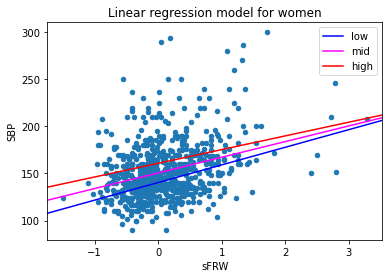

In [11]:
# We get the parameters of the model
p = fit.params
# We plot the data regarding SBP as a function of weight for females
fram[fram['SEX'] == 'female'].plot.scatter('sFRW', 'SBP')

# We plot the model predictions for three ranges of age to visualize the differences in
# SBP as a function of weight for each group

abline_plot(intercept=p.Intercept-p['sAGE'], slope=p.sFRW-p['sFRW:sAGE'], ax=plt.gca(), color='blue', label='low')

abline_plot(intercept=p.Intercept, slope=p.sFRW,ax=plt.gca(), color='magenta', label='mid')

abline_plot(intercept=p.Intercept+p['sAGE'], slope=p.sFRW+p['sFRW:sAGE'],ax=plt.gca(), color='red', label='high')

plt.title('Linear regression model for women')
plt.legend()

We can observe that for all age groups blood pressure increases with weight, but its levels are generally higher in older people. However, blood pressure is similar for women of all age groups in the high weight range.

### Increasing the accuracy of the model

To expand the model's predictive accuracy, we include the variable `sCIG` from the data and its interactions with the rest of the predictors already considered in the model. Then we plot the model for `SBP` as a function of the most important explanatory variable, visualizing different ranges of `sCHOL`, while keeping the rest of the variables at their mean values.

                            OLS Regression Results                            
Dep. Variable:                    SBP   R-squared:                       0.152
Model:                            OLS   Adj. R-squared:                  0.143
Method:                 Least Squares   F-statistic:                     16.50
Date:                Wed, 07 Jul 2021   Prob (F-statistic):           2.99e-40
Time:                        14:15:03   Log-Likelihood:                -6508.6
No. Observations:                1394   AIC:                         1.305e+04
Df Residuals:                    1378   BIC:                         1.313e+04
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept           151.3182      1.16

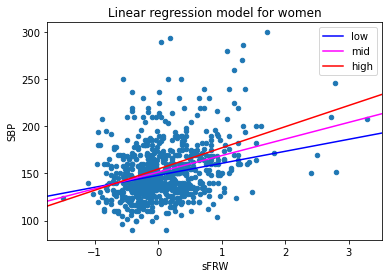

In [12]:
# We add the contribution of smoking and its interactions to expand the model
model = smf.ols('SBP ~ sFRW + SEX + sFRW:SEX + sCHOL + sFRW:sCHOL + SEX:sCHOL + sAGE + sFRW:sAGE + SEX:sAGE + sCHOL:sAGE + sCIG + sCIG:sFRW + sCIG:SEX + sCIG:sCHOL + sCIG:sAGE', data=fram)
# We fit the model and get the regression results
fit = model.fit()
print(fit.summary())

# We get the parameters of the model
p = fit.params
# We plot the data regarding SBP as a function of weight (the most explanatory variable)
fram[fram['SEX'] == 'female'].plot.scatter('sFRW', 'SBP')

# We plot the model predictions for three ranges of normalized cholesterol level to visualize the differences in
# SBP as a function of weight for each group

abline_plot(intercept=p.Intercept-p['sCHOL'], slope=p.sFRW-p['sFRW:sCHOL'], ax=plt.gca(), color='blue', label='low')

abline_plot(intercept=p.Intercept, slope=p.sFRW,ax=plt.gca(), color='magenta', label='mid')

abline_plot(intercept=p.Intercept+p['sCHOL'], slope=p.sFRW+p['sFRW:sCHOL'],ax=plt.gca(), color='red', label='high')
plt.title('Linear regression model for women')

plt.legend()

The model accuracy is similar, according to the adjusted R-squared value obtained, to the model that didn't include `sCIG` as an explanatory variable. Moreover, the p-values associated to `sCIG` and its interactions with the other values indicate that there is not a strong relationship between `sCIG` and `SBP`. 

## _Logistic regression_

The logistic regression model is useful to predict categorical variables, as it lets us calculate a probability using the sigmoid function and then make a binary classification of the results according to a threshold value.

First, we define the sigmoid function.

In [13]:
def logistic(x):
    return 1.0 / (1.0 + np.exp(-x))

Then, we define a categorical variable for high blood pressure, `HIGH_BP`, by restricting both the `SBP` and `DBP` columns. We fit the logistic regression model to predict `HIGH_BP` using weight and sex as explanatory variables, and compute the error as the average of false positives and false negatives.

In [14]:
# We define the numeric variable HIGH_BP according to a restriction applied to SBP and DBP
fram["HIGH_BP"]=(fram.SBP>=140)|(fram.DBP>=90)
fram.HIGH_BP=fram.HIGH_BP.astype(int)

# We fit the logistical regression model by using normalized weight, sex and
# its interactions as explanatory variables
model = smf.glm(formula='HIGH_BP ~ sFRW + SEX + SEX:sFRW', data=fram, family=sm.families.Binomial(statsmodels.genmod.families.links.logit()))
# We adjust the model and get the results
fit = model.fit()
print(fit.summary())

# We calculate the mean error as the sum of false positives and false negatives
error_rate_orig = np.mean(((fit.fittedvalues<0.5)&fram.HIGH_BP)|((fit.fittedvalues>0.5)& ~fram.HIGH_BP))

print('Error rate: ',error_rate_orig)

                 Generalized Linear Model Regression Results                  
Dep. Variable:                HIGH_BP   No. Observations:                 1394
Model:                            GLM   Df Residuals:                     1390
Model Family:                Binomial   Df Model:                            3
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -856.87
Date:                Wed, 07 Jul 2021   Deviance:                       1713.7
Time:                        14:15:03   Pearson chi2:                 1.39e+03
No. Iterations:                     4                                         
Covariance Type:            nonrobust                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            0.7631      0.082  

The error rate of the model, as defined previously, is above 35%. From the summary of GLM we can see that `SEX` and its interactions are not significantly correlated with HIGH_BP. If we remove it from the model:

In [15]:
# We fit the logistical regression model by using normalized weight
# as the only explanatory variable
model = smf.glm(formula='HIGH_BP ~ sFRW', data=fram, family=sm.families.Binomial(statsmodels.genmod.families.links.logit()))
# We adjust the model and get the results
fit = model.fit()
print(fit.summary())

# We calculate the mean error as the sum of false positives and false negatives
error_rate_orig = np.mean(((fit.fittedvalues<0.5)&fram.HIGH_BP)|((fit.fittedvalues>0.5)& ~fram.HIGH_BP))

print('Error rate: ',error_rate_orig)

                 Generalized Linear Model Regression Results                  
Dep. Variable:                HIGH_BP   No. Observations:                 1394
Model:                            GLM   Df Residuals:                     1392
Model Family:                Binomial   Df Model:                            1
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -858.64
Date:                Wed, 07 Jul 2021   Deviance:                       1717.3
Time:                        14:15:03   Pearson chi2:                 1.39e+03
No. Iterations:                     4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.6756      0.059     11.402      0.0

The error rate is lower than for the previous model, which verifies our assumptions.

If we consider `sAGE` and its interactions as predictors to expand the model, we get the following result:

In [16]:
# We expand the logistic regression model by adding the normalized age and its interactions
# as explanatory variables
model_s = smf.glm(formula='HIGH_BP ~ sFRW + SEX + SEX:sFRW + sAGE + sAGE:sFRW + sAGE:SEX', data=fram, family=sm.families.Binomial(statsmodels.genmod.families.links.logit()))

# We fit the model and get the results
fit_s = model_s.fit()
print(fit_s.summary())

# We calculate the mean error again for comparison purposes
error_rate = np.mean(((fit_s.fittedvalues<0.5)&fram.HIGH_BP)|((fit_s.fittedvalues>0.5)& ~fram.HIGH_BP))

print('Error rate: ',error_rate)

                 Generalized Linear Model Regression Results                  
Dep. Variable:                HIGH_BP   No. Observations:                 1394
Model:                            GLM   Df Residuals:                     1387
Model Family:                Binomial   Df Model:                            6
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -845.51
Date:                Wed, 07 Jul 2021   Deviance:                       1691.0
Time:                        14:15:03   Pearson chi2:                 1.39e+03
No. Iterations:                     4                                         
Covariance Type:            nonrobust                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            0.8079      0.084  

Adding `sAGE` as a predictor reduced the error in the model slightly. The summary results tell us again that `SEX` and its interactions have no significant correlation with the variable to predict. We can again verify our conclusions by removing `SEX` from the model.

In [17]:
model = smf.glm(formula='HIGH_BP ~ sFRW + sAGE + sAGE:sFRW', data=fram, family=sm.families.Binomial(statsmodels.genmod.families.links.logit()))

# We fit the model and get the results
fit = model.fit()
print(fit.summary())

# We calculate the mean error again for comparison purposes
error_rate = np.mean(((fit.fittedvalues<0.5)&fram.HIGH_BP)|((fit.fittedvalues>0.5)& ~fram.HIGH_BP))

print('Error rate: ',error_rate)

                 Generalized Linear Model Regression Results                  
Dep. Variable:                HIGH_BP   No. Observations:                 1394
Model:                            GLM   Df Residuals:                     1390
Model Family:                Binomial   Df Model:                            3
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -850.73
Date:                Wed, 07 Jul 2021   Deviance:                       1701.5
Time:                        14:15:03   Pearson chi2:                 1.39e+03
No. Iterations:                     4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.6922      0.060     11.562      0.0

The calculated error rate, as the proportion of false positives and false negatives, is similar even after removing the explanatory variable. This corroborates our assumption.

Next, we visualize the predicted probability of `HIGH_BP` as a function of `sFRW` for women and men, divided by age groups, returning to the previous model.

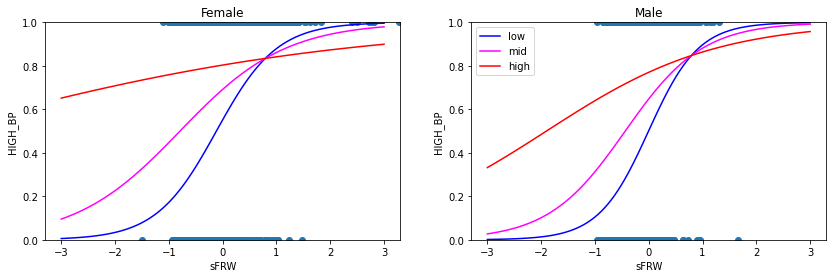

In [18]:
# We get the parameters of the models and plot the data values for HIGH_BP for men and female
# together with the logistic model regression curves for three age groups

p = fit_s.params

X = np.linspace(-3,3,100)

fig, ax = plt.subplots(1,2, subplot_kw={'xlim': (-3.3,3.3),'ylim': (0,1),'xlabel':'sFRW','ylabel':'HIGH_BP'},figsize=(14,4))

ax[0].scatter(fram.sFRW[fram['SEX']=='female'], fram.HIGH_BP[fram['SEX']=='female'])

ax[0].plot(X, logistic(X*(p.sFRW-p['sAGE:sFRW'])+p.Intercept-p['sAGE']), color='blue', label='low')

ax[0].plot(X, logistic(X*(p.sFRW)+p.Intercept), color='magenta', label='mid')

ax[0].plot(X, logistic(X*(p.sFRW+p['sAGE:sFRW'])+p.Intercept+p['sAGE']), color='red', label='high')

ax[0].set_title('Female')

ax[1].scatter(fram.sFRW[fram['SEX']=='male'], fram.HIGH_BP[fram['SEX']=='male'])

ax[1].plot(X, logistic(X*(p.sFRW-p['sAGE:sFRW']+p['SEX[T.male]:sFRW'])+p.Intercept-p['sAGE']+p['SEX[T.male]']), color='blue', label='low')

ax[1].plot(X, logistic(X*(p.sFRW+p['SEX[T.male]:sFRW'])+p.Intercept+p['SEX[T.male]']), color='magenta', label='mid')

ax[1].plot(X, logistic(X*(p.sFRW+p['sAGE:sFRW']+p['SEX[T.male]:sFRW'])+p.Intercept+p['sAGE']+p['SEX[T.male]']), color='red', label='high')

ax[1].set_title('Male')

plt.legend()


Both models predict a higher probability of having high blood pressure as weight increases for all age groups. The main difference is that the probability for `HIGH_BP` is significantly higher for females than males at lower weights.

Then, we create a helper function `train_test_split` that gets a DataFrame as parameter and return a pair of DataFrames splitted randomly using the `sample` method: one for training and the second for testing.

In [19]:
# We define a function to split a DataFrame into train and test groups for cross-validation purposes
def train_test_split(df, train_fraction=0.8):
    train_sample = df.sample(frac=train_fraction)
    test_sample = df.drop(train_sample.index)
    return train_sample, test_sample


We can now cross-validate the model. For this purpose, we use 100-fold cross validation and a training fraction of 0.8.

In [20]:
error_model=[]
np.random.seed(1)

# We split the data into random training and test sets, fit the model, predict the results and calculate
# the error rate 100 times. This way we can test the accuracy for the model
for i in range(100):
    train, test = train_test_split(fram)
    model = smf.glm(formula='HIGH_BP ~ sFRW + SEX + SEX:sFRW + sAGE + sAGE:sFRW + sAGE:SEX', data=train, family=sm.families.Binomial(statsmodels.genmod.families.links.logit()))
    fit = model.fit()
    pred = fit.predict(test, transform=True)
    error_rate_orig = np.mean(((pred<0.5)&(test.HIGH_BP))|((pred>0.5)& (~test.HIGH_BP)))
    error_model.append(error_rate_orig)

# We calculate the error as the mean of all errors calculated in the 100-fold cross-validation
error_rate = pd.Series(error_model).mean()
print('Error rate: ',error_rate)

Error rate:  0.3311827956989248


## _Predicting coronary heart disease_

As a final step in our analysis, we want to train a model to predict the 10-year risk of developing coronary heart disease. To accomplish this, we will use logistic regression adding to the data the binary variable `hasCHD`, that describes the event (`CHD > 0`, higher risk of 10-year occurence of coronary heart disease). The variable `hasCHD` can get only two values: 0 or 1, so calculating the mean tells us the proportion of positive cases.

In [21]:
# We define the binary variable hadCHD and check the proportion of positive cases
fram['hasCHD'] = (fram['CHD'] > 0).astype(int)
fram['hasCHD'].mean()


0.22022955523672882

Then, we create a logistic regression model for `hasCHD` by using `sCHOL`, `sCIG`, and `sFRW`, and their interactions as explanatory variables. Again, we calculate the error rate as the proportion of false positives and false negatives.

In [22]:
error_model=[]
np.random.seed(1)

def train_test_split(df, train_fraction=0.8):
    train_sample = df.sample(frac=train_fraction)
    test_sample = df.drop(train_sample.index)
    return train_sample, test_sample

# A logistic regression model is created, including smoking, cholesterol level, weight and its interactions
# as explanatory variables.

model = smf.glm(formula='hasCHD ~ sCHOL + sCIG + sCHOL:sCIG + sFRW + sFRW:sCHOL + sFRW:sCIG', data=fram, family=sm.families.Binomial(statsmodels.genmod.families.links.logit()))
fit = model.fit()
pred = fit.predict(fram, transform=True)
error_rate = np.mean(((pred<0.5)&(fram.hasCHD))|((pred>0.5)&(~fram.hasCHD)))
print(fit.summary())
print('Error rate: ',error_rate)


                 Generalized Linear Model Regression Results                  
Dep. Variable:                 hasCHD   No. Observations:                 1394
Model:                            GLM   Df Residuals:                     1387
Model Family:                Binomial   Df Model:                            6
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -721.19
Date:                Wed, 07 Jul 2021   Deviance:                       1442.4
Time:                        14:15:07   Pearson chi2:                 1.39e+03
No. Iterations:                     4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.2888      0.067    -19.101      0.0

We can see that the model has a 78% accuracy and the most relevant predictor is `sCIG`. In fact, `sCHOL` and its interactions are not relevant for the prediction. If we plot both the data and the model, we get the following result:

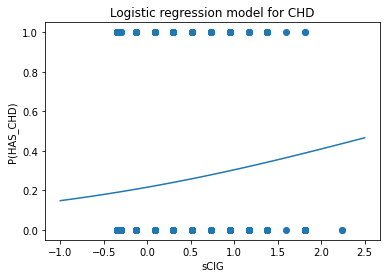

In [23]:
# We plot both the data points and the logistic curve for the most important explanatory variable of the model
X = np.linspace(-1,2.5,100)
p = fit.params
plt.scatter(fram.sCIG, fram.hasCHD)
plt.plot(X, logistic(X*p.sCIG+p.Intercept))
plt.ylabel('P(HAS_CHD)')
plt.xlabel('sCIG')
plt.title('Logistic regression model for CHD')
plt.show()

As it was calculated before, the model has an accuracy of approximately 78%, which makes its predictions significantly better than random guessing. We could use it to predict the development of CHD in the following 10-year period, taking as input a patient's cholesterol levels, smoking habits and weight.

If a person has cholestherol 200, smokes 17 cigarets per day, and has weight 100, then what is the probability that he/she sometimes shows signs of coronal hear disease? Note that the model expects normalized values. Store the normalized values to dictionary called `point`. Store the probability in variable `predicted`.

In [24]:
# We try the model by predicting coronal heart disease for a specific data point and store the
# probability value obtained
v_CHOL = (200 - fram.CHOL.mean())/(2*fram.CHOL.std())
v_CIG = (17 - fram.CIG.mean())/(2*fram.CIG.std())
v_FRW = (100 - fram.FRW.mean())/(2*fram.FRW.std())

point = {'sCHOL':v_CHOL, 'sCIG':v_CIG, 'sFRW':v_FRW}
predicted = fit.predict(point).values[0]
print('Predicted probability: ',predicted)
if predicted < 0.5:
    print('Prediction: No occurence of CHD in the next 10 years')
else:
    print('Prediction: Occurence of CHD in the next 10 years')

Predicted probability:  0.2161616602504101
Prediction: No occurence of CHD in the next 10 years


As we saw, a feature selection process could improve the relevance and accuracy of the model. This could lead to better and more useful predictions. It could be interesting to adjust the data to another binary classification models, like Decision Trees or KNN, to compare these results and find the optimal alternative.